In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from src.model import get_model, get_C_GL
from src.net import ObjSurrogate, Fixer
from src.utils import load_from_wandb
from src.dataset import EarlyFixingDataset, WellObjDataset

In [20]:
with open('../ef_objs_no_qglmax.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

wells = list(ef_objs.keys())

np.random.seed(42)
test_is = np.random.choice(len(wells), int(0.2 * len(wells)), replace=False)
test_wells = [wells[i] for i in test_is]
ef_objs_test = {w: ef_objs[w] for w in test_wells}

ds = EarlyFixingDataset(ef_objs_test)
len(ds)

100

In [21]:
from tqdm.notebook import tqdm

fixer = load_from_wandb(Fixer(layers=[25, 25, 25]), '7ozsc7v9', 'gef-fs')
fixer.eval()

logits = list()
z_cs = list()
z_gls = list()
for (bsw, gor, q_gl_max), (z_c, z_gl, obj, well_i) in tqdm(ds):
    with torch.no_grad():
        bsw = torch.Tensor([bsw,])
        gor = torch.Tensor([gor,])
        q_gl_max = torch.Tensor([q_gl_max,])

        logits.append(fixer(bsw, gor, q_gl_max))

        z_cs.append(z_c)
        z_gls.append(z_gl)
logit = torch.vstack(logits)
z_c = np.stack(z_cs)
z_gl = np.stack(z_gls)

  0%|          | 0/100 [00:00<?, ?it/s]

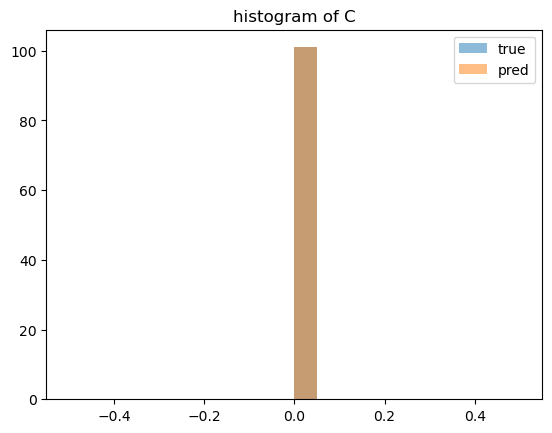

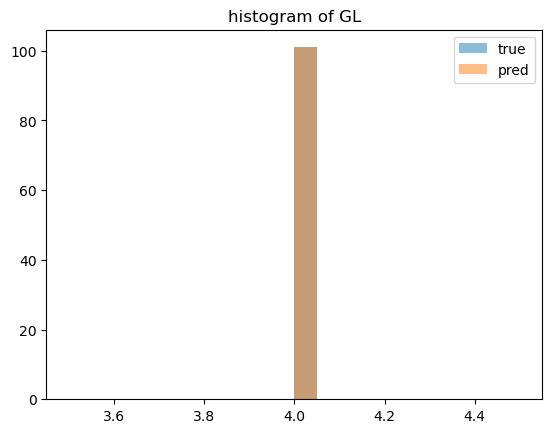

In [22]:
y_hat = torch.softmax(logit, -1)
y_pred = torch.argmax(logit, -1)

plt.title('histogram of C')
plt.hist(np.argmax(z_c, -1), bins=20, label='true', alpha=0.5)
plt.hist(y_pred[:,0], bins=20, label='pred', alpha=0.5)
plt.legend()
plt.show()

plt.title('histogram of GL')
plt.hist(np.argmax(z_gl, -1), bins=20, label='true', alpha=0.5)
plt.hist(y_pred[:,1], bins=20, label='pred', alpha=0.5)
plt.legend()
plt.show()

In [15]:
logits[0]

tensor([[[ 37.3583, -19.0295, -18.6242, -19.8573, -20.4647],
         [-44.3966,  -3.6685,   8.0744, -43.5086, -43.3378]]],
       grad_fn=<ViewBackward0>)

In [19]:
gor.shape

torch.Size([1, 1])

In [45]:
surrogate = load_from_wandb(ObjSurrogate(layers=[25, 25]), '7f8r3fp8', 'gef-fs').double()

ds = WellObjDataset(ef_objs_test)

C = list()
GL = list()
Y_hat = list()
Y = list()
for i in range(25):
    (bsw, gor, z_c, z_gl, q_gl_max), y = ds[i]
    C.append(z_c.argmax())
    GL.append(z_gl.argmax())

    with torch.no_grad():
        z_c = torch.Tensor(z_c).unsqueeze(0).double()
        z_gl = torch.Tensor(z_gl).unsqueeze(0).double()
        bsw = torch.Tensor([bsw,]).double()
        gor = torch.Tensor([gor,]).double()
        q_gl_max = torch.Tensor([q_gl_max,]).double()

        y_hat = surrogate(bsw, gor, z_c, z_gl, q_gl_max)

    Y.append(y)
    Y_hat.append(y_hat.item())

C = np.array(C).reshape(5,5)
GL = np.array(GL).reshape(5,5)
Y = np.array(Y).reshape(5,5)
Y_hat = np.array(Y_hat).reshape(5,5)

In [65]:
%matplotlib widget

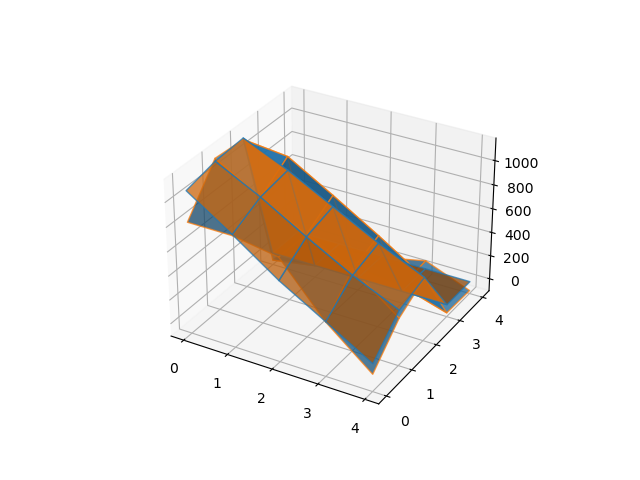

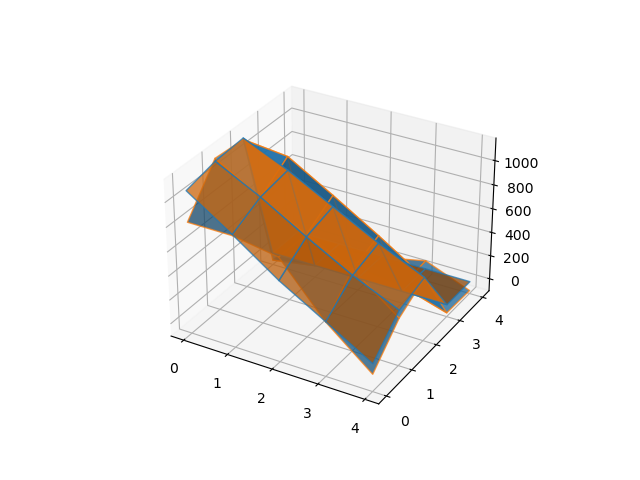

In [70]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(C, GL, Y_hat, alpha=0.75, edgecolor='tab:orange')
ax.plot_surface(C, GL, Y, alpha=0.75, edgecolor='tab:blue')
fig.show()

In [43]:
np.array(GL).reshape(5,5)

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [44]:
np.array(Y).reshape(5,5)

array([[ 1.07406292e+03,  1.13362280e+03,  1.15315765e+03,
        -1.00000000e+00, -1.00000000e+00],
       [ 8.28449183e+02,  9.46800642e+02,  9.88746536e+02,
        -1.00000000e+00, -1.00000000e+00],
       [ 5.68098030e+02,  7.29875045e+02,  7.93801667e+02,
        -1.00000000e+00, -1.00000000e+00],
       [ 3.49532901e+02,  5.27837581e+02,  5.99386232e+02,
        -1.00000000e+00, -1.00000000e+00],
       [ 1.26696165e+02,  3.57112982e+02,  4.28641849e+02,
        -1.00000000e+00, -1.00000000e+00]])

In [37]:
np.meshgrid(np.arange(5), np.arange(5))

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]])]

In [21]:
C, GL = get_C_GL(None)
C
# C, GL = np.meshgrid(C, GL)

array([10., 24., 38., 52., 66., 80.])